All imports and initialization
-----------------------------------------

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import tensorflow as tf
from pylab import rcParams
import matplotlib.pyplot as plt

# Sklearn imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, 
                             precision_recall_curve, 
                             recall_score, 
                             classification_report, 
                             auc, 
                             roc_curve, 
                             precision_recall_fscore_support, 
                             f1_score)

#Keras imports
from keras import regularizers
from keras.layers import Input, Dense
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, TensorBoard

# seeds and figsize initialization
RANDOM_SEED = 314 #used to help randomly select the data points
TEST_PCT = 0.2 # 20% of the data

rcParams['figure.figsize'] = 14, 8.7
LABELS = ["Normal","Fraud"]
col_list = ["cerulean","scarlet"]

/home/nepalai/.virtualenvs/deeplearning/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
Using TensorFlow backend.


Importing our synthesized data
----------------------------------------------
Now, we are importing a sample data called "sample_data.csv"  
Download source: https://www.kaggle.com/mlg-ulb/creditcardfraud/home#  
Everything except the time and amount has been reduced by a Principle Component Analysis (PCA) for privacy concerns.
PCA: https://code.likeagirl.io/principal-component-analysis-dimensionality-reduction-technique-step-by-step-approach-ffd46623ff67

Data format:
-------------------
Time | Features (V1, V2, ..., V28) | Amount | Class (0 or 1 labels)

In [2]:
df = pd.read_csv("sample_data.csv")
df.head(n=5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.shape

(284807, 31)

Now, we'd like to check the number of labels (0 and 1) and their distribution.

In [4]:
pd.value_counts(df['Class'], sort = True)

0    284315
1       492
Name: Class, dtype: int64

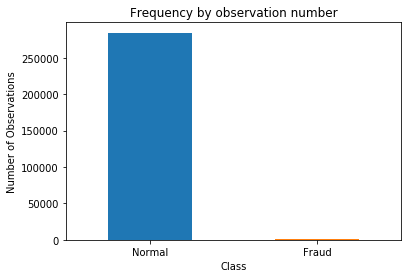

In [5]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2), LABELS)
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");

In [6]:
normal_df = df[df.Class == 0] # normal_df are non-fraud types (Class=0)
fraud_df = df[df.Class == 1] # fraud_df are fraudulent types (Class=1)

In [7]:
normal_df.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [8]:
fraud_df.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

/home/nepalai/.virtualenvs/deeplearning/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


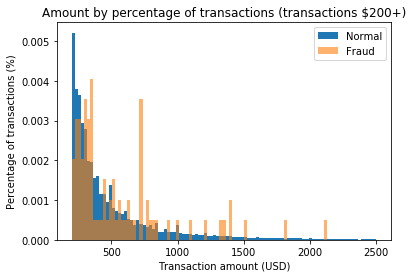

In [9]:
#plot of high value transactions
bins = np.linspace(200, 2500, 100)
plt.hist(normal_df.Amount, bins, alpha=1, normed=True, label='Normal')
plt.hist(fraud_df.Amount, bins, alpha=0.6, normed=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Amount by percentage of transactions (transactions \$200+)")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions (%)");
plt.show()

### Thus, the above method doesn't seem to be a reliable way to classify fraudulent and non-fraudulent data.

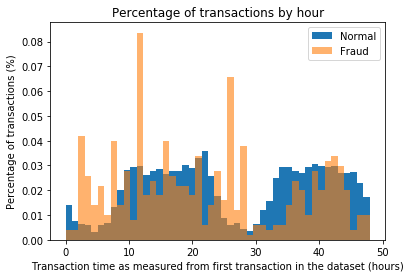

In [10]:
bins = np.linspace(0, 48, 48) #48 hours
plt.hist((normal_df.Time/(60*60)), bins, alpha=1, normed=True, label='Normal')
plt.hist((fraud_df.Time/(60*60)), bins, alpha=0.6, normed=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Percentage of transactions by hour")
plt.xlabel("Transaction time as measured from first transaction in the dataset (hours)")
plt.ylabel("Percentage of transactions (%)");
#plt.hist((df.Time/(60*60)),bins)
plt.show()

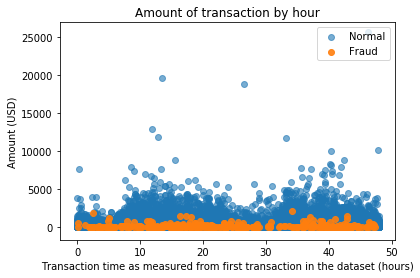

In [11]:
plt.scatter((normal_df.Time/(60*60)), normal_df.Amount, alpha=0.6, label='Normal')
plt.scatter((fraud_df.Time/(60*60)), fraud_df.Amount, alpha=0.9, label='Fraud')
plt.title("Amount of transaction by hour")
plt.xlabel("Transaction time as measured from first transaction in the dataset (hours)")
plt.ylabel('Amount (USD)')
plt.legend(loc='upper right')
plt.show()

## Looks like all these techniques can hardly distinguish fraud or non-fraud data.

## We now apply PCA to Time and Amount columns as well.

In [12]:
# Apply PCA
#data = df.drop(['Time'], axis=1) #if you think the var is unimportant
df_norm = df
df_norm['Time'] = StandardScaler().fit_transform(df_norm['Time'].values.reshape(-1, 1))
df_norm['Amount'] = StandardScaler().fit_transform(df_norm['Amount'].values.reshape(-1, 1))

In [13]:
train_x, test_x = train_test_split(df_norm, test_size=TEST_PCT, random_state=RANDOM_SEED)
train_x = train_x[train_x.Class == 0] #where normal transactions
train_x = train_x.drop(['Class'], axis=1) #drop the class column


test_y = test_x['Class'] #save the class column for the test set
test_x = test_x.drop(['Class'], axis=1) #drop the class column

train_x = train_x.values #transform to ndarray
test_x = test_x.values

In [14]:
train_x.shape

(227468, 30)

## In comes Autoencoder

In [15]:
nb_epoch = 100
batch_size = 128
input_dim = train_x.shape[1]
encoding_dim = 14
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-7

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [16]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="autoencoder_fraud.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(train_x, train_x,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(test_x, test_x),
                    verbose=1,
                    callbacks=[cp, tb]).history

Train on 227468 samples, validate on 56962 samples
Epoch 1/100
227468/227468 [==============================] - 4s 16us/step - loss: 0.8534 - acc: 0.5098 - val_loss: 0.8196 - val_acc: 0.5831
Epoch 2/100
227468/227468 [==============================] - 3s 14us/step - loss: 0.7672 - acc: 0.6092 - val_loss: 0.7856 - val_acc: 0.6381
Epoch 3/100
227468/227468 [==============================] - 3s 13us/step - loss: 0.7431 - acc: 0.6528 - val_loss: 0.7706 - val_acc: 0.6627
Epoch 4/100
227468/227468 [==============================] - 4s 15us/step - loss: 0.7316 - acc: 0.6709 - val_loss: 0.7624 - val_acc: 0.6790
Epoch 5/100
227468/227468 [==============================] - 4s 18us/step - loss: 0.7225 - acc: 0.6818 - val_loss: 0.7529 - val_acc: 0.6848
Epoch 6/100
227468/227468 [==============================] - 3s 13us/step - loss: 0.7173 - acc: 0.6851 - val_loss: 0.7500 - val_acc: 0.6839
Epoch 7/100
227468/227468 [==============================] - 3s 15us/step - loss: 0.7145 - acc: 0.6852 - val_

Epoch 59/100
227468/227468 [==============================] - 3s 12us/step - loss: 0.7007 - acc: 0.7029 - val_loss: 0.7344 - val_acc: 0.7050
Epoch 60/100
227468/227468 [==============================] - 3s 12us/step - loss: 0.7005 - acc: 0.7034 - val_loss: 0.7351 - val_acc: 0.6972
Epoch 61/100
227468/227468 [==============================] - 3s 12us/step - loss: 0.7004 - acc: 0.7032 - val_loss: 0.7341 - val_acc: 0.7074
Epoch 62/100
227468/227468 [==============================] - 3s 14us/step - loss: 0.7003 - acc: 0.7041 - val_loss: 0.7347 - val_acc: 0.7049
Epoch 63/100
227468/227468 [==============================] - 3s 14us/step - loss: 0.7006 - acc: 0.7041 - val_loss: 0.7344 - val_acc: 0.7035
Epoch 64/100
227468/227468 [==============================] - 4s 15us/step - loss: 0.7003 - acc: 0.7040 - val_loss: 0.7353 - val_acc: 0.7035
Epoch 65/100
227468/227468 [==============================] - 3s 13us/step - loss: 0.7003 - acc: 0.7042 - val_loss: 0.7344 - val_acc: 0.7046
Epoch 66/100


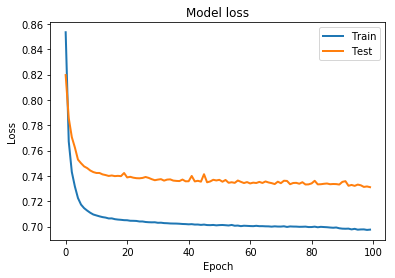

In [17]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [18]:
test_x_predictions = autoencoder.predict(test_x)
mse = np.mean(np.power(test_x - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_y})
error_df.describe()

,Reconstruction_error,True_class
count,56962.000000,56962.000000
mean,0.731001,0.002019
std,3.153325,0.044887
min,0.056379,0.000000
25%,0.241424,0.000000
50%,0.385896,0.000000
75%,0.616432,0.000000
max,190.064191,1.000000


## Generating the ROC curve

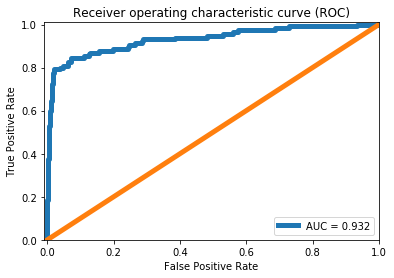

In [19]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Precision vs Recall

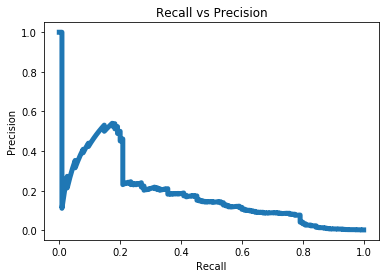

In [20]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(recall_rt, precision_rt, linewidth=5, label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

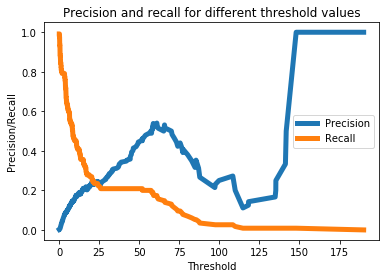

In [21]:
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

## If the error is larger than a predefined threshold, we'll mark it as a fraud. See the figure below. (About 63% accuracy)

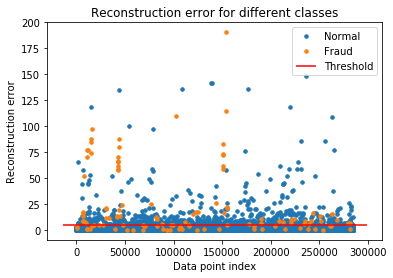

In [22]:
threshold_fixed = 5
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

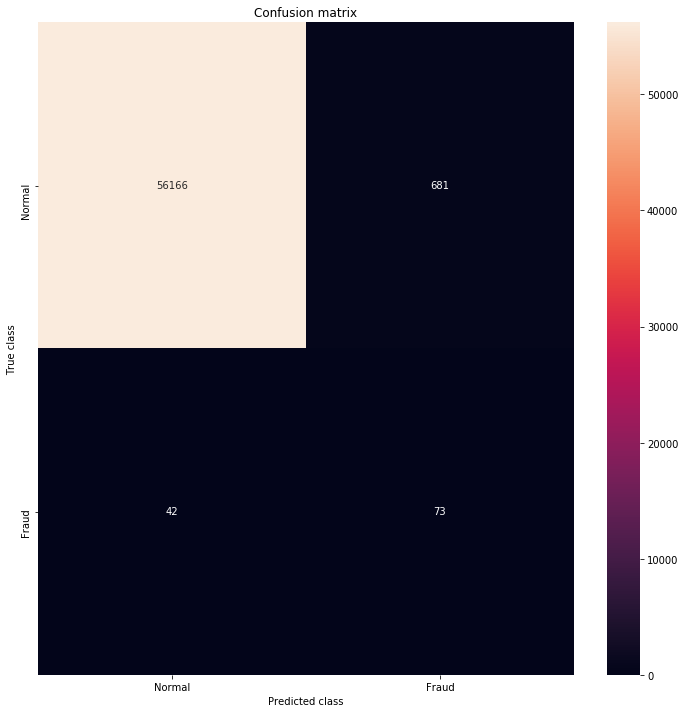

In [23]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()